### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [ ]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\USER\anaconda3\envs\Unet\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\USER\anaconda3\envs\Unet\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\USER\anaconda3\envs\Unet\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\USER\anaconda3\envs\Unet\lib\site-packages\t

In [2]:
DATA_DIR = r'F:\001Unet_model\segmentation_models-master_yangmin\data\CamVid\grape'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    #CLASSES = ['background','rice','none']
    CLASSES = ['a', 'b', 'c', 'd', 'e']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

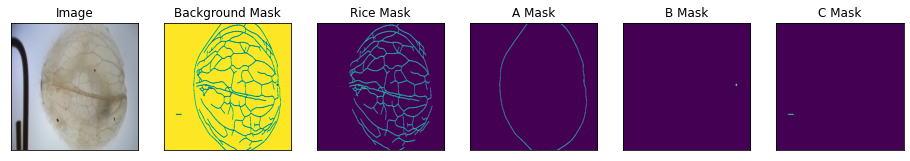

In [5]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['a', 'b', 'c', 'd', 'e'])

image, mask = dataset[14] # get some sample
visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
   # duckweed_mask=mask[..., 2].squeeze(),
    rice_mask=mask[..., 1].squeeze(),
    a_mask=mask[..., 2].squeeze(),
    b_mask=mask[..., 3].squeeze(),
    c_mask=mask[..., 4].squeeze(),
    #d_mask=mask[..., 5].squeeze(),    
    #e_mask=mask[..., 6].squeeze(),
   # f_mask=mask[..., 7].squeeze(),    
   # g_mask=mask[..., 8].squeeze(),
    #h_mask=mask[..., 9].squeeze(),
    #i_mask=mask[..., 10].squeeze(),
    #j_mask=mask[..., 11].squeeze(),
   # k_mask=mask[..., 12].squeeze(),
    #l_mask=mask[..., 13].squeeze(),    
    #m_mask=mask[..., 14].squeeze(),
    #n_mask=mask[..., 15].squeeze(),    
    #o_mask=mask[..., 16].squeeze()    
   
)

In [6]:
mask.shape

(512, 512, 6)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [7]:
import albumentations as A

In [8]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\albumentations\imgaug\transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\albumentations\imgaug\transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\albumentations\augmentations\transforms.py:1151: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\albumentations\imgaug\transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please 

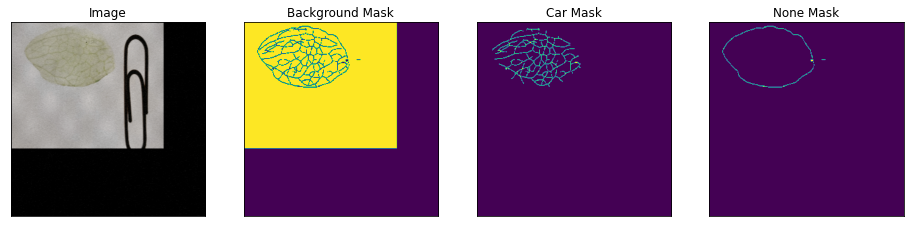

In [9]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['a', 'b'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    car_mask=mask[..., 1].squeeze(),
    none_mask=mask[..., 2].squeeze(),
)

# Segmentation model training

In [10]:
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import numpy as np

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import keras.backend as K

class CosineAnnealingScheduler(Callback):
    def __init__(self, T_max, eta_min=0, verbose=0):
        """
        T_max: 完整的周期（单位为 epoch）
        eta_min: 最小学习率
        """
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')

        # 计算学习率
        lr = self.eta_min + (self.model.optimizer.lr - self.eta_min) * \
             (1 + np.cos(np.pi * epoch / self.T_max)) / 2

        # 更新学习率
        self.model.optimizer.lr.assign(lr)

        # 在 TensorFlow 1.x 中，必须通过会话获取实际数值
        session = K.get_session()
        lr_value = session.run(lr)  # 获取实际的学习率值

        # 打印学习率，lr_value 是标量，可以直接格式化输出
        if self.verbose > 0:
            print(f"\nEpoch {epoch + 1}: Learning rate is {lr_value:.6f}.")




Segmentation Models: using `keras` framework.


In [11]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
#without background class
CLASSES = ['a', 'b', 'c', 'd']
LR = 0.0005
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [12]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# 创建 U-Net 模型，加载预训练权重
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

In [13]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 2,0.5,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# 编译模型
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

In [14]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
# 回调函数：保存模型和 CosineAnnealing 学习率调整
callbacks = [
    ModelCheckpoint('./grape1211_opt.h5', save_weights_only=True, save_best_only=True, monitor='val_iou_score', mode='max'),
    CosineAnnealingScheduler(T_max=EPOCHS, eta_min=1e-6, verbose=1),  # CosineAnnealing 调度器
]

In [38]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/100

Epoch 1: Learning rate is 0.000500.
131/131 [==============================] - 94s 721ms/step - loss: 0.6852 - iou_score: 0.2366 - f1-score: 0.2924 - val_loss: 0.6719 - val_iou_score: 0.3011 - val_f1-score: 0.3633
Epoch 2/100

Epoch 2: Learning rate is 0.000500.
131/131 [==============================] - 145s 1s/step - loss: 0.5370 - iou_score: 0.3431 - f1-score: 0.4093 - val_loss: 0.5984 - val_iou_score: 0.3570 - val_f1-score: 0.4190
Epoch 3/100

Epoch 3: Learning rate is 0.000500.
131/131 [==============================] - 42s 317ms/step - loss: 0.5161 - iou_score: 0.3520 - f1-score: 0.4190 - val_loss: 0.5973 - val_iou_score: 0.3546 - val_f1-score: 0.4168
Epoch 4/100

Epoch 4: Learning rate is 0.000499.
131/131 [==============================] - 42s 318ms/step - loss: 0.5102 - iou_score: 0.3579 - f1-score: 0.4248 - val_loss: 0.5891 - val_iou_score: 0.3488 - val_f1-score: 0.4076
Epoch 5/100

Epoch 5: Learning rate is 0.000498.
131/131 [==============================] - 42

Epoch 37/100

Epoch 37: Learning rate is 0.000357.
131/131 [==============================] - 43s 328ms/step - loss: 0.4701 - iou_score: 0.3473 - f1-score: 0.4159 - val_loss: 0.5610 - val_iou_score: 0.3779 - val_f1-score: 0.4445
Epoch 38/100

Epoch 38: Learning rate is 0.000350.
131/131 [==============================] - 43s 331ms/step - loss: 0.4645 - iou_score: 0.3551 - f1-score: 0.4247 - val_loss: 0.5601 - val_iou_score: 0.3822 - val_f1-score: 0.4490
Epoch 39/100

Epoch 39: Learning rate is 0.000342.
131/131 [==============================] - 43s 327ms/step - loss: 0.4622 - iou_score: 0.3673 - f1-score: 0.4370 - val_loss: 0.5530 - val_iou_score: 0.3860 - val_f1-score: 0.4511
Epoch 40/100

Epoch 40: Learning rate is 0.000335.
131/131 [==============================] - 43s 329ms/step - loss: 0.4651 - iou_score: 0.3563 - f1-score: 0.4261 - val_loss: 0.5392 - val_iou_score: 0.3812 - val_f1-score: 0.4484
Epoch 41/100

Epoch 41: Learning rate is 0.000328.
131/131 [========================

Epoch 73/100

Epoch 73: Learning rate is 0.000091.
131/131 [==============================] - 44s 334ms/step - loss: 0.4552 - iou_score: 0.3707 - f1-score: 0.4413 - val_loss: 0.5482 - val_iou_score: 0.3840 - val_f1-score: 0.4496
Epoch 74/100

Epoch 74: Learning rate is 0.000086.
131/131 [==============================] - 45s 347ms/step - loss: 0.4518 - iou_score: 0.3607 - f1-score: 0.4319 - val_loss: 0.5396 - val_iou_score: 0.3815 - val_f1-score: 0.4485
Epoch 75/100

Epoch 75: Learning rate is 0.000080.
131/131 [==============================] - 44s 335ms/step - loss: 0.4480 - iou_score: 0.3646 - f1-score: 0.4359 - val_loss: 0.5467 - val_iou_score: 0.3813 - val_f1-score: 0.4467
Epoch 76/100

Epoch 76: Learning rate is 0.000074.
131/131 [==============================] - 51s 387ms/step - loss: 0.4496 - iou_score: 0.3623 - f1-score: 0.4335 - val_loss: 0.5201 - val_iou_score: 0.3739 - val_f1-score: 0.4410
Epoch 77/100

Epoch 77: Learning rate is 0.000069.
131/131 [========================

AttributeError: 'Model' object has no attribute '_ckpt_saved_epoch'

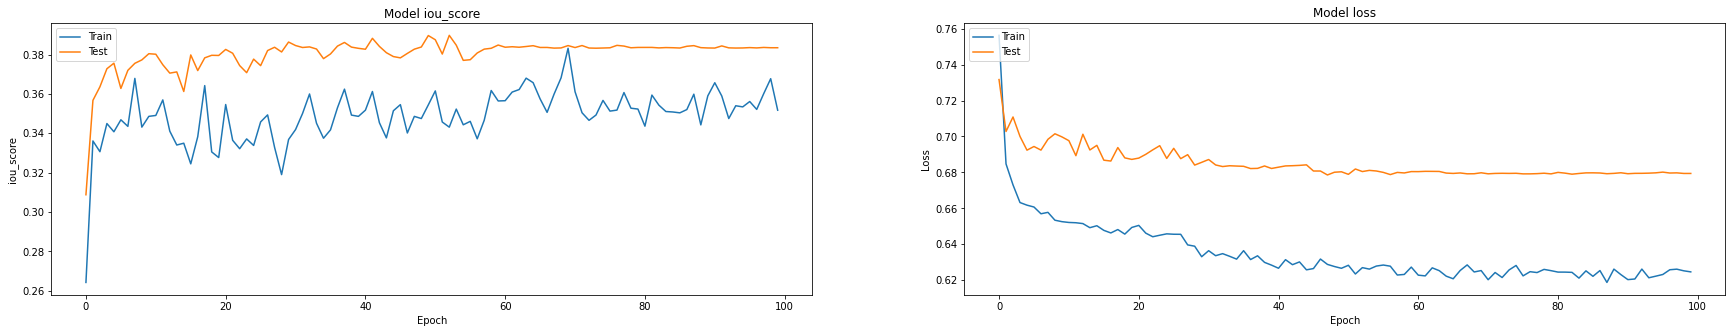

In [39]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('grape1211.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

# Visualization of results on test dataset

In [15]:
import cv2
import skimage.io as io
x_test_dir = r'F:\000DLdataset\grape\ZHU_TableGrape_0529\rgb'
save_path = r'F:\000DLdataset\grape\ZHU_TableGrape_0529\mask'

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    
    #------ if input is not 512, fill to 512 ------- #
    #augmentation=get_validation_augmentation(),
    
    preprocessing=get_preprocessing(preprocess_input),
)
# result = os.path.join(DATA_DIR, 'testannot')
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
# load best weights
model.load_weights('./grape1211_opt.h5') 

#####random choose for urtal dataset#######
####number of the test dataset imgs####
#n = 124
#ids = np.random.choice(np.arange(len(test_dataset)), size=n)

#####total choose for test dataset#######
ids =np.arange(len(test_dataset))
fileList = os.listdir(x_test_dir)
for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = cv2.resize(np.array(image), (896, 640))
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    predictions = np.expand_dims((pr_mask), axis=0)
    predictions = np.squeeze(predictions)  
    predictions = np.argmax(predictions, axis=2) 
    
    
##### visualize  ######    
#     visualize(
#         image=denormalize(image.squeeze()),
#         #gt_mask=gt_mask[..., 0].squeeze(),
#         pr_mask=pr_mask[..., 0].squeeze(),
#     )

   
    cv2.imwrite(os.path.join(save_path,"%s"%fileList[i]),predictions)
    #io.imsave(os.path.join(save_path,"%s"%fileList[i]),predictions)

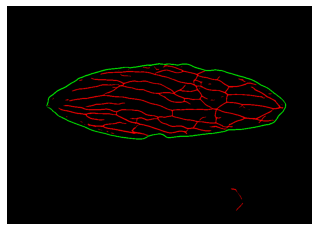

In [16]:
## 可视化部分图像
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 定义类别的颜色映射
class_colors = [
    (0, 0, 0),      # 类别0，黑色
    (255, 0, 0),    # 类别1，红色
    (0, 255, 0),    # 类别2，绿色
    (0, 0, 255),    # 类别3，蓝色
    (255, 255, 0),  # 类别4，黄色
]

# 将每个像素值映射到相应的颜色
def visualize_segmentation(image_path):
    # 读取单通道图像
    img = np.array(Image.open(image_path), dtype=np.uint8)

    # 创建一个RGB图像
    color_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    # 将每个类别映射到相应的颜色
    for i in range(5):  # 有5个类别
        color_image[img == i] = class_colors[i]

    # 显示图像
    plt.imshow(color_image)
    plt.axis('off')
    plt.show()

# 使用示例图像路径
image_path = r'F:\000DLdataset\grape\ZHU_TableGrape_0529\mask/table_MF_b1_1.png'
visualize_segmentation(image_path)
